In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Set custom styles for text color
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'  # Color of the x-axis tick values
plt.rcParams['ytick.color'] = 'white'  # Color of the y-axis tick values

import seaborn as sns

# tensorflow
import tensorflow as tf
import tensorflow_decision_forests as tfdf 

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2023-08-27 09:57:21.491038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.shape

(1459, 2)

In [3]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [4]:
data = pd.read_csv('data/train.csv')
data.shape

(1460, 81)

In [5]:
# some missing values but tfdf can handle this
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Let's visualize some data

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'Sale Price Distribution')

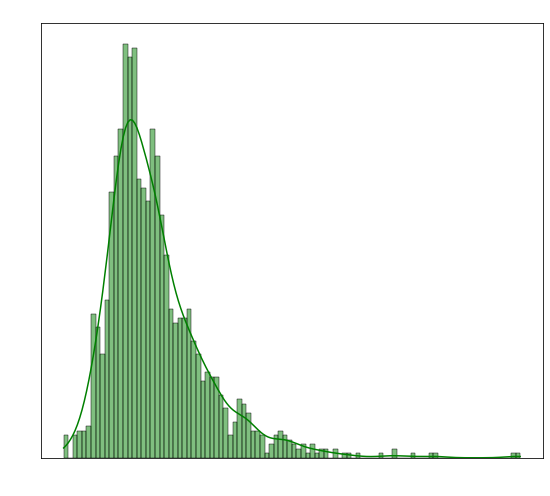

In [6]:
display(data['SalePrice'].describe())
plt.figure(figsize=(9,8))

sns.histplot(data['SalePrice'], color='g', bins=100, kde=True)
plt.title('Sale Price Distribution')


In [7]:
data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

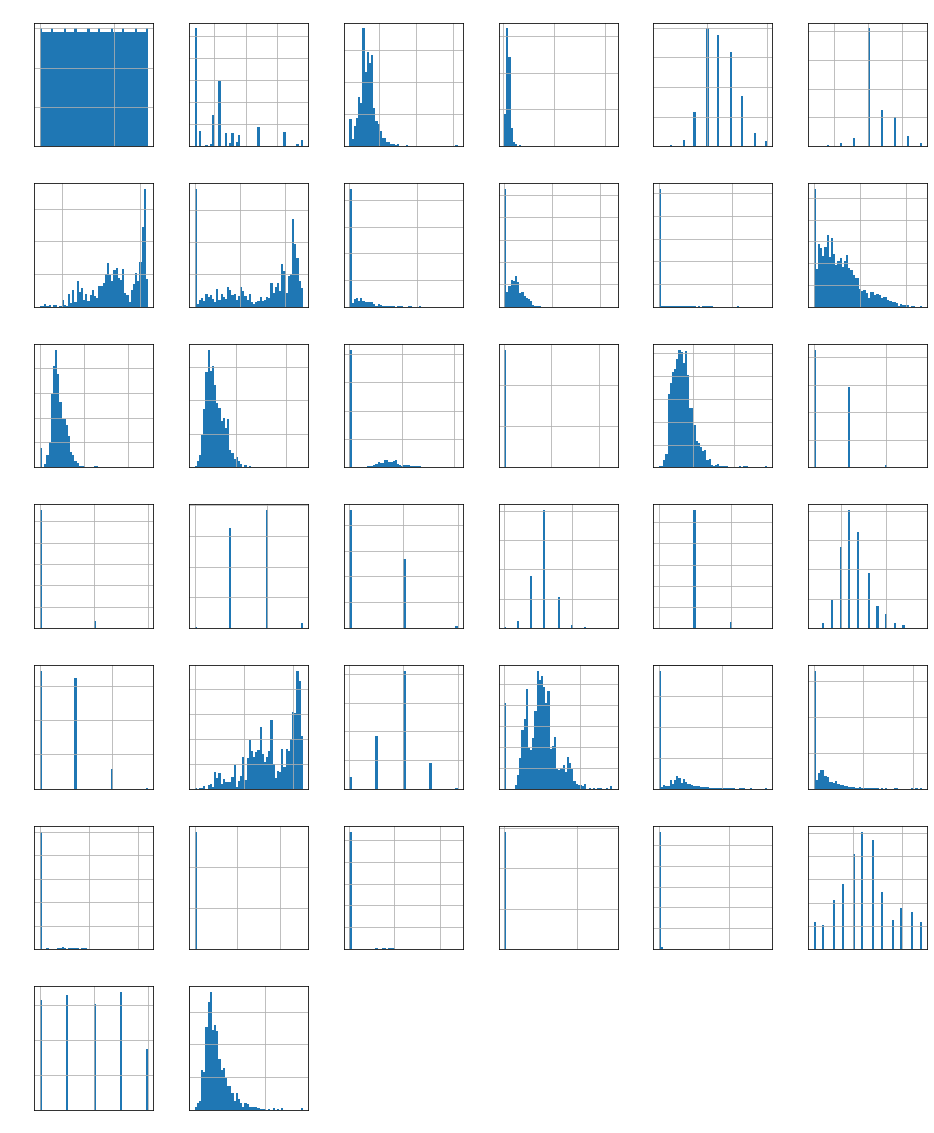

In [8]:
data_num = data.select_dtypes(include=['int64', 'float64'])
data_num.hist(figsize=(16,20), bins=50, xlabelsize=8, ylabelsize=8);

### Data preparation

In [9]:
label = 'SalePrice'
data.drop('Id', axis=1, inplace=True) # don't need the key

In [10]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
data.shape

(1460, 80)

In [12]:
def train_test_split(data, test_ratio = 0.3):
    test_indices = np.random.rand(len(data)) < test_ratio
    return data[~test_indices], data[test_indices]

train_data, test_data = train_test_split(data)
print('{} samples in training data, {} samples in testing data'.format(train_data.shape[0],
                                                                      test_data.shape[0]))

1031 samples in training data, 429 samples in testing data


In [13]:
# convert pandas to tensorflow datasets
train_data = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label, 
                                      task=tfdf.keras.Task.REGRESSION)
test_data = tfdf.keras.pd_dataframe_to_tf_dataset(test_data, label=label,
                                     task=tfdf.keras.Task.REGRESSION)

### Model: TFDF

In [14]:
rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION)
rf.compile(metrics='mse')

Use /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmprz8ucmm0 as temporary training directory


In [15]:
rf.fit(x=train_data)

Reading training dataset...
Training dataset read in 0:00:03.972429. Found 1031 examples.
Training model...


[INFO 23-08-27 09:59:06.3303 MDT kernel.cc:1243] Loading model from path /var/folders/3s/l2m1db5135751grhtk16_j200000gn/T/tmprz8ucmm0/model/ with prefix 5c29c01fe0cf4839
[INFO 23-08-27 09:59:06.5179 MDT decision_forest.cc:660] Model loaded with 300 root(s), 98080 node(s), and 76 input feature(s).
[INFO 23-08-27 09:59:06.5179 MDT abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-08-27 09:59:06.5180 MDT kernel.cc:1075] Use fast generic engine


Model trained in 0:00:00.662020
Compiling model...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [16]:
tfdf.model_plotter.plot_model_in_colab(rf, max_depth=5, tree_idx=0)

In [17]:
logs = rf.make_inspector().training_logs()
display(logs)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=380, accuracy=None, loss=None, rmse=44461.6351320085, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=12, evaluation=Evaluation(num_examples=992, accuracy=None, loss=None, rmse=38732.891406739676, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=23, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=32524.385987196438, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=33, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=31590.893168659022, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=43, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=30963.913014659385, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=53, evaluation=Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=30956.447363521092, ndcg=None, aucs=None, auuc=None, qini=None)),
 TrainLog(num_trees=63, evaluatio

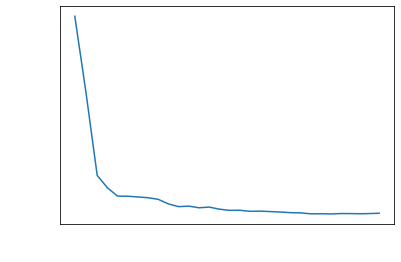

In [18]:
# OOB: Out of Bags, rf chooses random sample to train, so this helps to visualize the training accuracy
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.show()

In [19]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1031, accuracy=None, loss=None, rmse=29677.56910677615, ndcg=None, aucs=None, auuc=None, qini=None)

In [20]:
# let's evaluate using our testing set
evaluation = rf.evaluate(x=test_data, return_dict=True)
display(evaluation)

1/1 [==============================] - 0s 445ms/step - loss: 0.0000e+00 - mse: 1022212672.0000


{'loss': 0.0, 'mse': 1022212672.0}

### Variable importance

In [21]:
# num_as_root, which feature is best suited for root
# inv_mean_min_depth, helps understand how quickly each feature appreach in the tree
#      early it appears, more importance it is
# sum_score: how important is a feature contributing towards the end result
# num_nodes: total number of nodes in decision tree
inspector.variable_importances().keys()

dict_keys(['INV_MEAN_MIN_DEPTH', 'SUM_SCORE', 'NUM_AS_ROOT', 'NUM_NODES'])

In [22]:
inspector.variable_importances()['SUM_SCORE'][0:5]

[("OverallQual" (1; #62), 462715969500642.75),
 ("Neighborhood" (4; #59), 235062589496462.12),
 ("GrLivArea" (1; #38), 220995423710532.4),
 ("ExterQual" (4; #22), 143247601271221.62),
 ("GarageCars" (1; #32), 107173743364614.0)]

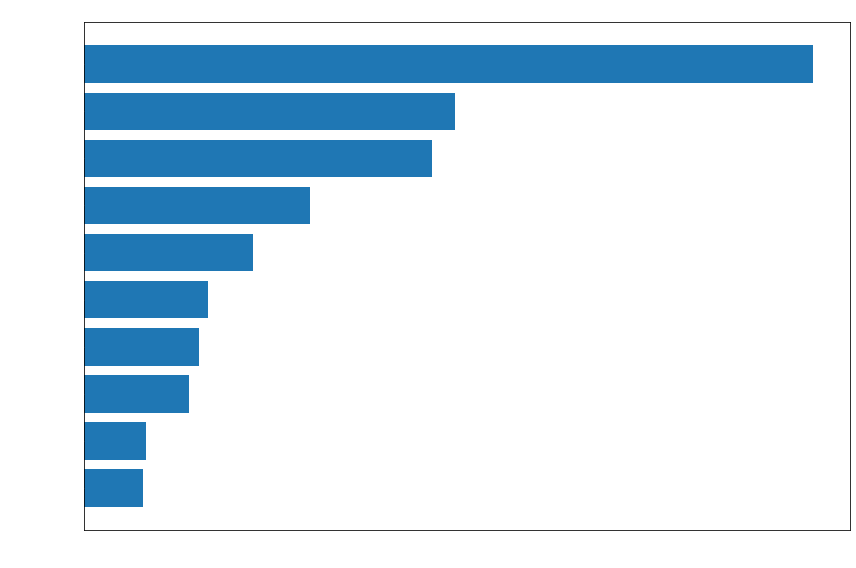

In [23]:
plt.figure(figsize=(12,8))

var_importance_metric = 'SUM_SCORE'
var_importances = inspector.variable_importances()[var_importance_metric]

feature_names = [v[0].name for v in var_importances][0:10]
feature_importance = [v[1] for v in var_importances][0:10]

# since they are in descending importance already
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_names, feature_importance, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis() # inverses order of bars appearing

for importance, patch in zip(feature_importance, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance/1e12:.0f}T", va="top")

plt.xlabel('Importance')
plt.title(var_importance_metric + ' feature importance')
plt.tight_layout()
plt.show()

### Predictions

In [24]:
prod_data = pd.read_csv('data/test.csv')
prod_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [25]:
prod_data.shape

(1459, 80)

In [26]:
indices = prod_data.pop('Id')

In [27]:
prod_ts = tfdf.keras.pd_dataframe_to_tf_dataset(prod_data, 
                                                     task=tfdf.keras.Task.REGRESSION)
predictions = rf.predict(prod_ts)

output = pd.DataFrame({'Id': indices, 'SalePrice': predictions.squeeze()})
output.head()

2/2 [==============================] - 1s 14ms/step


,Id,SalePrice
0,1461,126419.500000
1,1462,155031.203125
2,1463,177913.906250
3,1464,182735.046875
4,1465,200660.062500


### Submissions

In [29]:
submission = pd.read_csv('data/sample_submission.csv')
submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


In [30]:
submission.loc[submission['Id'].isin(output['Id']), 'SalePrice'] = output['SalePrice']

In [31]:
submission.head()

,Id,SalePrice
0,1461,126419.500000
1,1462,155031.203125
2,1463,177913.906250
3,1464,182735.046875
4,1465,200660.062500


In [32]:
submission.to_csv('data/submission.csv', index=False)